In [1]:
# !pip install ipywidgets widgetsnbextension pandas-profiling

In [2]:
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
# import seaborn as sns
# import random
import torch
import numpy as np
from tqdm import tqdm

In [3]:
# GOOGL

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2000-01-01'  # '2014-01-01'  # 2012-10-21
end_date = '2022-11-22'  # '2014-10-20'  # 2022

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader('IBM', 'yahoo', start_date, end_date)

# Resample the data to normalize it, the data comes without any data on the (days that the markets are close, weekends)
panel_data = panel_data.resample("D").max()

# Fill the data in the closed markets with the data from the previous trading day, because it is their true value
panel_data = panel_data.fillna(method="ffill")

panel_data[panel_data.index.name] = panel_data.index
panel_data.index.name = None
panel_data = panel_data[['Date', 'High', 'Low', 'Open', 'Close', 'Volume']]  # , 'Adj Close']]
panel_data.reset_index(drop=True, inplace=True)

# panel_data.head(20)

In [4]:
date = pd.to_datetime(panel_data.pop('Date'), format='%Y-%m-%d')

In [5]:
plot_cols = ['High', 'Low', 'Open', 'Close', 'Volume']  # , 'Adj Close']
# plot_cols = ['High', 'Low', 'Open', 'Close', 'Adj Close']
plot_features = panel_data[plot_cols]
plot_features.index = date
# _ = plot_features.plot(subplots=True)


In [6]:
# panel_data.describe().transpose()

In [7]:
# panel_data.drop(columns=['Volume'], axis=1, inplace=True)
# panel_data

In [8]:
# Calculate percentage change

panel_data['Open'] = panel_data['Open'].pct_change()
panel_data['High'] = panel_data['High'].pct_change()
panel_data['Low'] = panel_data['Low'].pct_change()
panel_data['Close'] = panel_data['Close'].pct_change()
# panel_data['Adj Close'] = panel_data['Adj Close'].pct_change()

panel_data['Volume'] = panel_data['Volume'].pct_change()
panel_data.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
# panel_data

In [9]:
# Normalize price columns
min_return = min(panel_data[['Open', 'High', 'Low', 'Close']].min(axis=0)) # , 'Adj Close'
max_return = max(panel_data[['Open', 'High', 'Low', 'Close']].max(axis=0)) # , 'Adj Close'

# Min-max normalize price columns (0-1 range)
panel_data['Open'] = (panel_data['Open'] - min_return) / (max_return - min_return)
panel_data['High'] = (panel_data['High'] - min_return) / (max_return - min_return)
panel_data['Low'] = (panel_data['Low'] - min_return) / (max_return - min_return)
panel_data['Close'] = (panel_data['Close'] - min_return) / (max_return - min_return)
# panel_data['Adj Close'] = (panel_data['Adj Close'] - min_return) / (max_return - min_return)


# Normalize volume column
min_volume = panel_data['Volume'].min(axis=0)
max_volume = panel_data['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
panel_data['Volume'] = (panel_data['Volume'] - min_volume) / (max_volume - min_volume)


In [10]:
# Create training, validation and test split
times = sorted(panel_data.index.values)
last_10pct = sorted(panel_data.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(panel_data.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = panel_data[(panel_data.index < last_20pct)]  # Training data are 80% of total data
df_val = panel_data[(panel_data.index >= last_20pct) & (panel_data.index < last_10pct)]
df_test = panel_data[(panel_data.index >= last_10pct)]

In [11]:
# # Remove date column
# df_train.drop(columns=['Date'], inplace=True)
# df_val.drop(columns=['Date'], inplace=True)
# df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print(f'Training data shape: {train_data.shape}')
print(f'Validation data shape: {val_data.shape}')
print(f'Test data shape: {test_data.shape}')

Training data shape: (6688, 5)
Validation data shape: (836, 5)
Test data shape: (835, 5)


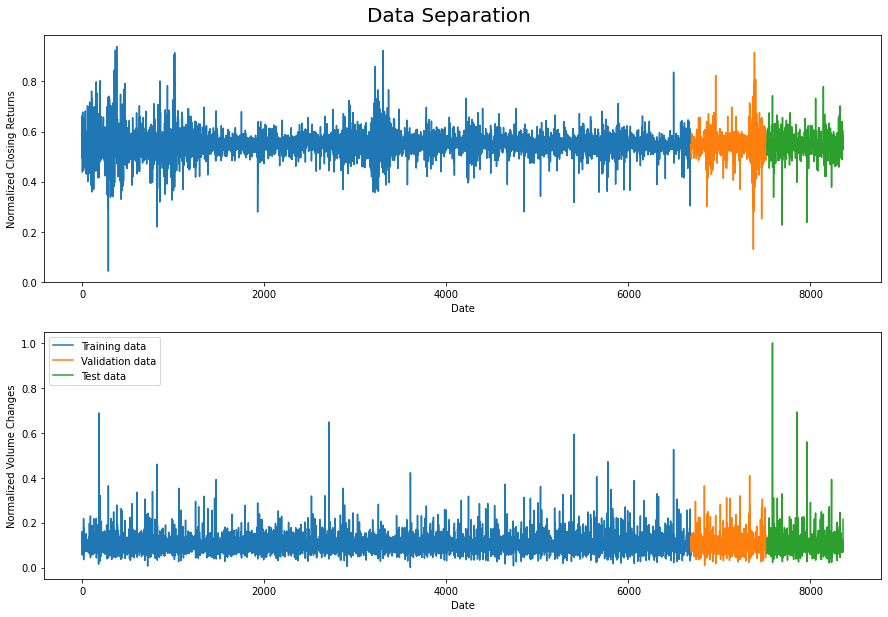

In [12]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')

plt.legend(loc='best')

In [13]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import random, math

### Set device

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Hyperparameters

In [15]:
sequence_length = 128  # [sequence_length] sequences of [input_size] features
input_size = 5
num_layers = 2
hidden_size = 256
num_features = 5  # averiguar
learning_rate = 0.001
batch_size = 64
num_epochs = 200

### Create Bidirectional LSTM

In [16]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_features):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch_first=True -> first layer that takes in the DataSet
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_features)
    
    def forward(self, x):
        # h0 = hidden state
        # c0 = cell state
        # self.num_layers * 2 -> tensor expanded x2 for concatenated state values of "going from begining to end and end to begining"
        # x.size(0) = number of examples sent in -> batch size
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)

        out, (hiddenState, cellState) = self.lstm(x, (h0, c0))  # (hiddenState, cellState) are not used -> can be replaced as _
        # out[:, -1, :] -> select the last hidden state to send to the linear layer
        # [:, -1, :] -> [all training examples, last hidden state, all the features]
        # out = out.reshape(out.shape[0], -1)
        out = self.fc(out[:, -1, :])

        return out



### Load Data

#### DataSet

In [17]:
# from torch.utils.data import Dataset

In [18]:
class DataSetter(Dataset):
    def __init__(self, dataframe, input_width, target_width):
        if dataframe is not None:
            self.inputs = []
            self.targets = []
            dataframe_np = np.array(dataframe)

            for i in range(0, len(dataframe_np) - input_width + 1, input_width):
                self.inputs.append(torch.FloatTensor(dataframe_np[i : i + input_width]))
            for t in range(0, len(dataframe_np) - target_width, input_width):  # target_width ??
                self.targets.append(torch.Tensor(dataframe_np[t : t + target_width]))

    def __getitem__(self, index):
        return {'inputs': self.inputs[index], 
                'targets':self.targets[index]}

    def __len__(self):
        return min(len(self.inputs), len(self.targets))


In [19]:
input_width, target_width = 5, 3

In [20]:
train_dataset = DataSetter(dataframe = train_data, input_width = input_width, target_width = target_width)
val_dataset = DataSetter(dataframe = val_data, input_width = input_width, target_width = target_width)
test_dataset = DataSetter(dataframe = test_data, input_width = input_width, target_width = target_width)

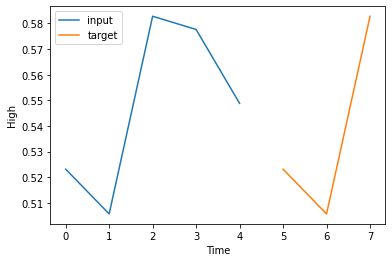

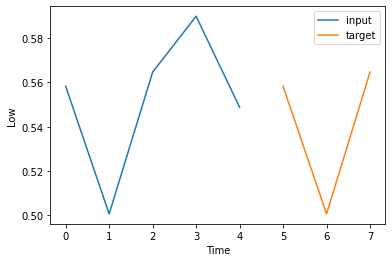

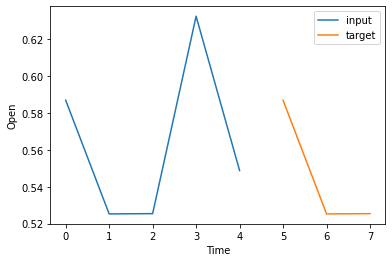

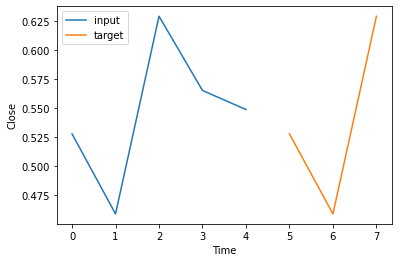

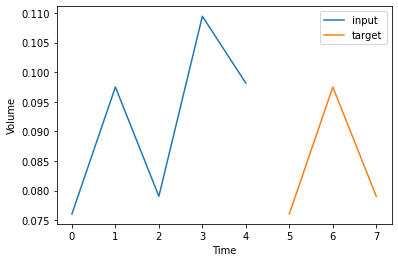

In [21]:
# import random
# Let's visualize some examples
idx = random.randint(0, len(train_dataset))
inputs = train_dataset[idx]['inputs'].numpy()
targets = train_dataset[idx]['targets'].numpy()

for i in range(train_data.shape[1]):  # number of columns (parameters)
    plt.plot(range(input_width), inputs[:,i], label='input')
    plt.plot(range(input_width, input_width + target_width), targets[:,i], label='target')
    plt.ylabel(plot_cols[i])
    plt.xlabel('Time')
    plt.legend()
    plt.show()

#### DataLoader

In [22]:
# from torch.utils.data import DataLoader

In [23]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_data = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [36]:
train_loader.dataset[0]['inputs'].shape, train_loader.dataset[0]['targets'].shape

(torch.Size([5, 5]), torch.Size([3, 5]))

In [25]:
# dataiter = iter(train_loader)
# datas = dataiter.next()
# # print(datas.values())
# features, labels = datas.values()
# print(features, labels)

In [26]:
# train_data
# val_data
# test_data

### Intitialize network

In [27]:
model = BiLSTM(input_size, hidden_size, num_layers, num_features).to(device)  # -> classification

### Loss and optimizer

In [28]:
# import torch.optim as optim

In [29]:
criterion = nn.MSELoss()  # nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train Network

In [30]:
# # type(data_in)
# for batch_idx, (data_combo) in enumerate(train_loader):
#     data_in = data_combo['inputs']
#     targets = data_combo['targets']
#     # print(data_in, targets)



#     # print(batch_idx)
#     # print(targets.values)
#     # print(data_in.values())
#     # (data_in, targets)
# # for _, batch in enumerate(train_loader):
# #     print(batch["targets"].shape[1])

In [37]:
# import math
n_iterations = math.ceil(len(train_dataset)/4)

for epoch in range(num_epochs):
    for batch_idx, (data_combo) in enumerate(train_loader):
        # Identify Data
        data_in = data_combo['inputs']
        targets = data_combo['targets']
        
        # Forward Backward
        if (i+1) % 5 == 0:
            print(f'epoch {epoch + 1}/{num_epochs}, step {i + 1}/{n_iterations}, inputs {inputs.shape}')
        
        # Get data to CUDA device
        data_in = data_in.to(device=device)#.squeeze(1)
        targets = targets.to(device=device)

        # # Get to correct shape
        # data_in = data_in.reshape(data_in.shape[0], -1)

        # forward
        scores = model(data_in)
        # print(scores)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or Adam step
        optimizer.step()

epoch 1/200, step 5/335, inputs (5, 5)


C:\Users\João Ferreira\AppData\Roaming\Python\Python37\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([64, 3, 5])) that is different to the input size (torch.Size([64, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (64) must match the size of tensor b (3) at non-singleton dimension 1

### Check accuracy on training & test to see how good our model is

In [ ]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on training data')
    else:
        print('Checking accuracy on test data')
    
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device).squeeze(1)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions ==  y).sum()